# Creating an Analytical Dataset
## Data Cleaning and Preparation
Udacity Business Analyst Nanodegree Project #2.1

### Import Libraries

In [19]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import Datasets

In [20]:
df_demographics = pd.read_csv('p2-wy-demographic-data.csv')
df_naics = pd.read_csv('p2-wy-453910-naics-data.csv')
df_population = pd.read_csv('p2-partially-parsed-wy-web-scrape.csv')
df_sales = pd.read_csv('p2-2010-pawdacity-monthly-sales.csv')

### Data Exploration and Cleaning

#### NAICS Market Data

In [21]:
df_naics['City'] = df_naics.pop('PHYSICAL CITY NAME')
df_naics.head()

,BUSINESS NAME,SALES VOLUME,CASS_LastLine,City
0,Mile High Mobile Pet LLC,300000,"Cheyenne, WY 82007-3528",Cheyenne
1,Pets City Inc,640000,"Cheyenne, WY 82009-4851",Cheyenne
2,Petco Animal Sups Stores Inc,0,"Cheyenne, WY 82009-4945",Cheyenne
3,Pet-A-Care,81000,"Cheyenne, WY 82009-1009",Cheyenne
4,Muddy Paws Pet Salon,76000,"Laramie, WY 82070-8979",Laramie


#### U.S. Census Population Data

In [22]:
df_population = df_population.dropna(subset=['City|County'])
df_population['City'], df_population['County'] = df_population['City|County'].str.split('|').str
df_population['City'] = df_population['City'].apply(lambda x: x.replace('?',''))
df_population['City'] = df_population['City'].apply(lambda x: x.strip())
df_population['2014 Estimate'] = df_population['2014 Estimate'].apply(lambda x: x.split('<')[1].replace('td>','').replace(',',''))
df_population['2000 Census'] = df_population['2000 Census'].apply(lambda x: x.split('<')[1].replace('td>','').replace(',',''))
df_population['2010 Census'] = df_population['2010 Census'].apply(lambda x: x.split('<')[1].replace('td>','').replace(',',''))
df_population = df_population[['City', 'County', '2000 Census', '2010 Census', '2014 Estimate']]
df_population = df_population.set_index(['City', 'County'])
df_population.head()

,,2000 Census,2010 Census,2014 Estimate
City,County,,,
Afton,Lincoln,1818,1911,1968
Albin,Laramie,120,181,185
Alpine,Lincoln,550,828,845
Baggs,Carbon,348,440,439
Bairoil,Sweetwater,97,106,107


#### Wyoming Demographics Data by City/County w/ Population Join

In [23]:
df_demographics = df_demographics.set_index(['City', 'County'])
df_demographics = df_demographics.join(df_population, how='inner')
df_demographics = df_demographics.reset_index().set_index('City')
df_demographics.head()

,County,Land Area,Households with Under 18,Population Density,Total Families,2000 Census,2010 Census,2014 Estimate
City,,,,,,,,
Afton,Lincoln,853.806650,497,0.93,1040.41,1818,1911,1968
Albin,Laramie,7.685902,37,0.10,74.87,120,181,185
Alpine,Lincoln,366.598892,213,0.40,446.72,550,828,845
Baggs,Carbon,253.240322,62,0.06,129.53,348,440,439
Bairoil,Sweetwater,29.459830,18,0.01,33.70,97,106,107


#### Pawdacity 2010 Sales Data by Month

In [24]:
df_sales['August'] = df_sales.pop('August ')
df_sales.head()

,NAME,ADDRESS,CITY,STATE,ZIP,January,February,March,April,May,June,July,September,October,November,December,August
0,Pawdacity,509 Fort St # A,Buffalo,WY,82834,16200,13392,14688,17064,18360,14040,12960,15984,13392,13176,16848,19224
1,Pawdacity,601 SE Wyoming Blvd Unit 252,Casper,WY,82609,29160,21600,27000,27648,29160,27216,25488,22896,25272,28944,27648,25704
2,Pawdacity,1400 Dell Range Blvd,Cheyenne,WY,82009,47520,44280,47088,46656,43200,45144,44064,47736,42984,44712,47304,45360
3,Pawdacity,3769 E Lincolnway,Cheyenne,WY,82001,32400,26352,31968,30888,30456,32832,29808,30780,31536,30024,32616,32184
4,Pawdacity,2625 Big Horn Ave,Cody,WY,82414,19440,15984,19008,18144,16632,17496,18792,19224,18144,18576,16632,20304


### Data Blending / Preparation

In [25]:
# Group sales by city
groupby_city = df_sales.groupby(by='CITY')
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
df_sales_by_city = \
    groupby_city[months].agg('sum')

In [26]:
# Blend demographics/population and sales dataframes to create training dataframe
df_train = df_sales_by_city.join(df_demographics)
df_train['Total Sales'] = df_train[months].sum(axis=1)
df_train.drop(months + ['2000 Census', '2014 Estimate', 'County'], axis=1, inplace=True)
df_train['2010 Census Population'] = df_train.pop('2010 Census')
df_train = df_train.apply(lambda x: x.apply(float))
# Rearrange Columns
df_train = df_train[['2010 Census Population', 'Total Sales',
                     'Households with Under 18', 'Land Area',
                     'Population Density', 'Total Families']]

# Print sum of each feature
df_train.sum()

2010 Census Population      2.138620e+05
Total Sales                 3.773304e+06
Households with Under 18    3.406400e+04
Land Area                   3.307138e+04
Population Density          6.280000e+01
Total Families              6.265279e+04
dtype: float64

In [27]:
df_train_all = df_train.append(pd.DataFrame(df_train.sum(), columns=['TOTAL']).T)
df_train_all = df_train_all.append(pd.DataFrame(df_train.mean(), columns=['AVERAGE']).T)
df_train_all

,2010 Census Population,Total Sales,Households with Under 18,Land Area,Population Density,Total Families
Buffalo,4585.0,1.853280e+05,746.000000,3115.507500,1.550000,1819.500000
Casper,35316.0,3.177360e+05,7788.000000,3894.309100,11.160000,8756.320000
Cheyenne,59466.0,9.178920e+05,7158.000000,1500.178400,20.340000,14612.640000
Cody,9520.0,2.183760e+05,1403.000000,2998.956960,1.820000,3515.620000
Douglas,6120.0,2.080080e+05,832.000000,1829.465100,1.460000,1744.080000
Evanston,12359.0,2.838240e+05,1486.000000,999.497100,4.950000,2712.640000
Gillette,29087.0,5.431320e+05,4052.000000,2748.852900,5.800000,7189.430000
Powell,6314.0,2.339280e+05,1251.000000,2673.574550,1.620000,3134.180000
Riverton,10615.0,3.032640e+05,2680.000000,4796.859815,2.340000,5556.490000
Rock Springs,23036.0,2.535840e+05,4022.000000,6620.201916,2.780000,7572.180000


### Outlier Detection

In [28]:
IQR = df_train.quantile(q=0.75)-df_train.quantile(q=0.25)
Upper_Fence = df_train.quantile(q=0.75) + 1.5*IQR
Lower_Fence = df_train.quantile(q=0.25) - 1.5*IQR

for row, value in df_train.iterrows():
#     print(row)
    for key in value.keys():
        if value[key] > Upper_Fence[key]:
            print(key + ' exceeds upper fence in ' + row)
        elif value[key] < Lower_Fence[key]:
            print(key + ' exceeds lower fence in ' + row)

2010 Census Population exceeds upper fence in Cheyenne
Total Sales exceeds upper fence in Cheyenne
Population Density exceeds upper fence in Cheyenne
Total Families exceeds upper fence in Cheyenne
Total Sales exceeds upper fence in Gillette
Land Area exceeds upper fence in Rock Springs


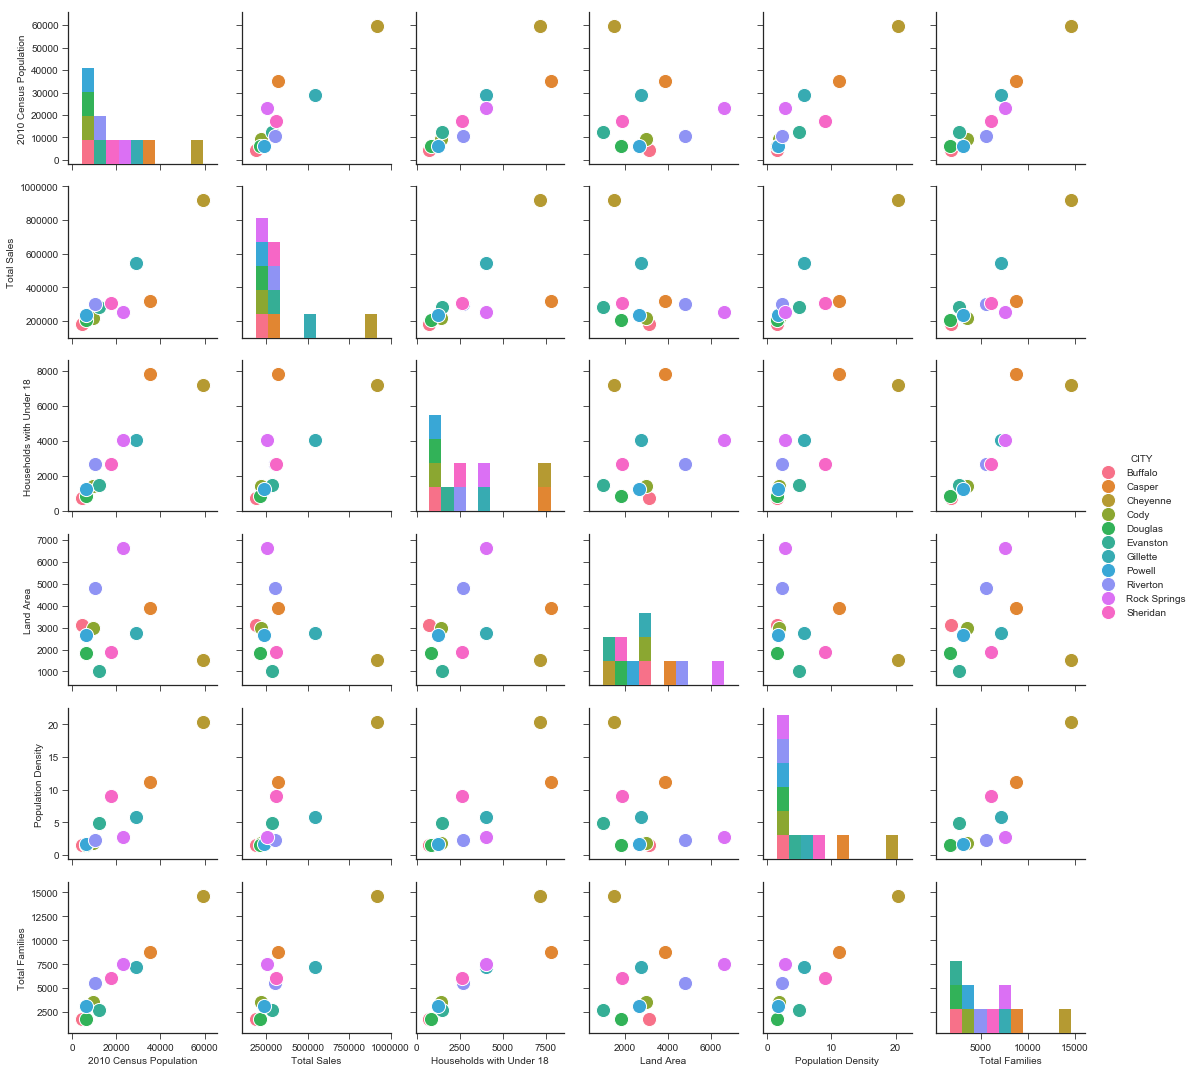

In [29]:
sns.pairplot(df_train.reset_index(), hue='CITY', plot_kws={'s': 200})

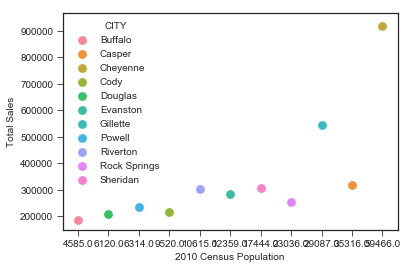

In [30]:
# sns.regplot(data=df_train.reset_index(), x='Land Area', y='Total Sales')
sns.pointplot(data=df_train.reset_index(), x='2010 Census Population', y='Total Sales', hue='CITY')

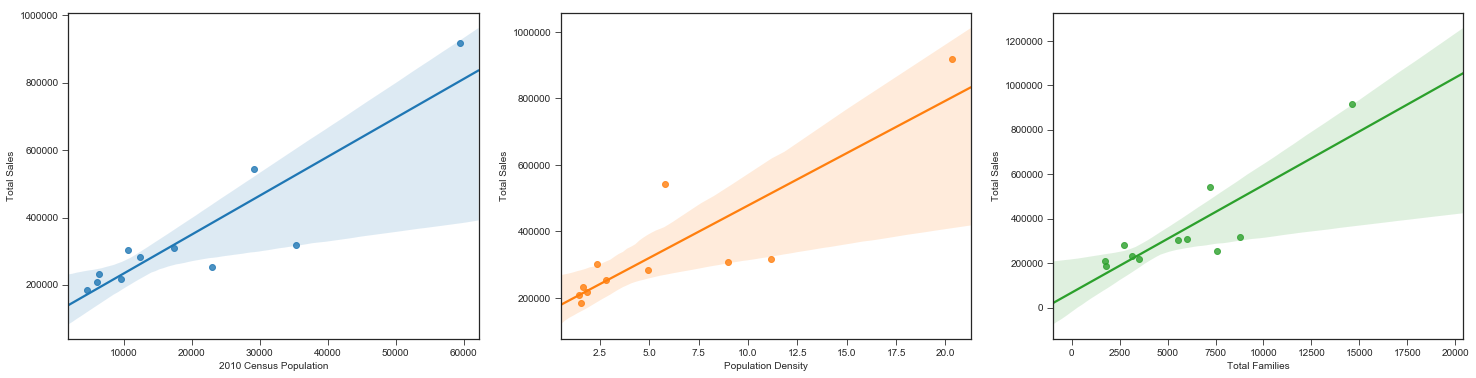

In [31]:
sns.set_style('ticks')
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,6))
sns.regplot(data=df_train, x='2010 Census Population', y='Total Sales', ax=ax1)
sns.regplot(data=df_train, x='Population Density', y='Total Sales', ax=ax2)
sns.regplot(data=df_train, x='Total Families', y='Total Sales', ax=ax3)

In [32]:
df_train.drop('Gillette', inplace=True)
df_train

,2010 Census Population,Total Sales,Households with Under 18,Land Area,Population Density,Total Families
CITY,,,,,,
Buffalo,4585.0,185328.0,746.0,3115.507500,1.55,1819.50
Casper,35316.0,317736.0,7788.0,3894.309100,11.16,8756.32
Cheyenne,59466.0,917892.0,7158.0,1500.178400,20.34,14612.64
Cody,9520.0,218376.0,1403.0,2998.956960,1.82,3515.62
Douglas,6120.0,208008.0,832.0,1829.465100,1.46,1744.08
Evanston,12359.0,283824.0,1486.0,999.497100,4.95,2712.64
Powell,6314.0,233928.0,1251.0,2673.574550,1.62,3134.18
Riverton,10615.0,303264.0,2680.0,4796.859815,2.34,5556.49
Rock Springs,23036.0,253584.0,4022.0,6620.201916,2.78,7572.18


# Make Predictions using Analytical Dataset

## Select Predictor Variables

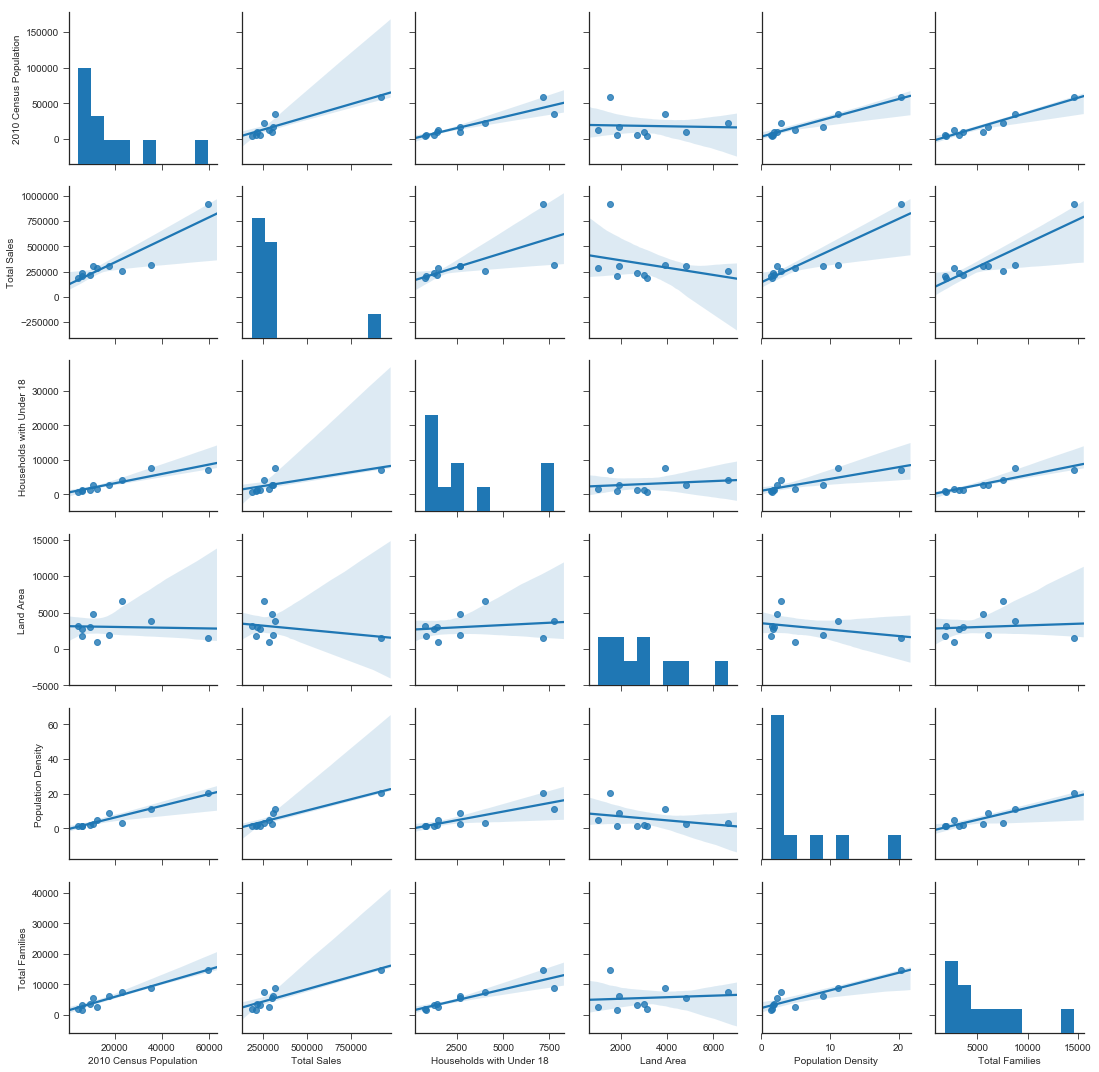

In [33]:
sns.pairplot(df_train, kind='reg')

Use all variables

In [34]:
df_train.corr()

,2010 Census Population,Total Sales,Households with Under 18,Land Area,Population Density,Total Families
2010 Census Population,1.000000,0.898755,0.911562,-0.052470,0.944389,0.969190
Total Sales,0.898755,1.000000,0.674652,-0.287078,0.906180,0.874663
Households with Under 18,0.911562,0.674652,1.000000,0.189376,0.821986,0.905660
Land Area,-0.052470,-0.287078,0.189376,1.000000,-0.317419,0.107304
Population Density,0.944389,0.906180,0.821986,-0.317419,1.000000,0.891680
Total Families,0.969190,0.874663,0.905660,0.107304,0.891680,1.000000


Land Area is not correlated with other variables

Population, Households with Under 18, Population Density, and Total Families are all highly correlated (>0.9)

In [51]:
feature_test = ['2010 Census Population',
                'Households with Under 18',
                'Population Density',
                'Total Families']

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

for feature in feature_test:
    training_set = ['Land Area', feature]
    reg = LinearRegression()
    reg.fit(df_train[training_set], df_train['Total Sales'])
    r2_value = r2_score(df_train['Total Sales'], reg.predict(df_train[training_set]))
    print('{}: {:0.4f}'.format(feature, r2_value))

2010 Census Population: 0.8655
Households with Under 18: 0.6336
Population Density: 0.8212
Total Families: 0.9118


In [58]:
# Best Feature -> Total Families
features = ['Land Area', 'Total Families']

In [61]:
# Create and fit model
reg = LinearRegression()
reg.fit(df_train[features], df_train['Total Sales'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [72]:
# Equation
print('Predicted Sales = {:0.2f} + ({:0.2f})*(Land Area) + ({:0.2f})*(Total Families)'.format(reg.intercept_, reg.coef_[0], reg.coef_[1]))

Predicted Sales = 197330.41 + (-48.42)*(Land Area) + (49.14)*(Total Families)


## Create Dataframe of Possible Cities for New Store

Criteria for new store:
- The new store should be located in a new city.

- The total sales for the entire competition in the new city should be less than $500,000

- The new city where you want to build your new store must have a population over 4,000 people (based on 2014 US Census)

- The predicted yearly sales must be over $200,000

- The city chosen has the highest predicted sales from the predicted set

In [62]:
df_naics.head()

,BUSINESS NAME,SALES VOLUME,CASS_LastLine,City
0,Mile High Mobile Pet LLC,300000,"Cheyenne, WY 82007-3528",Cheyenne
1,Pets City Inc,640000,"Cheyenne, WY 82009-4851",Cheyenne
2,Petco Animal Sups Stores Inc,0,"Cheyenne, WY 82009-4945",Cheyenne
3,Pet-A-Care,81000,"Cheyenne, WY 82009-1009",Cheyenne
4,Muddy Paws Pet Salon,76000,"Laramie, WY 82070-8979",Laramie


In [63]:
groupby_city = df_naics.groupby('City')
df_competitors = groupby_city.agg('sum')

In [64]:
possible_cities = []
for city in list(df_competitors[df_competitors['SALES VOLUME'] < 500000].index):
    if city not in list(df_train_all.index):
        possible_cities.append(city)
print(len(possible_cities))
print('')
print('Possible Cities:')
print('----------------')
for city in possible_cities:
    print(city)

10

Possible Cities:
----------------
Alpine
Dubois
Evansville
Jackson
Kemmerer
Lander
Laramie
Saratoga
Wheatland
Worland


In [65]:
df_possible_cities = df_demographics.loc[possible_cities]\
                                    .reset_index()\
                                    .merge(df_competitors.reset_index(), on='City')
df_possible_cities['2014 Estimate'] = df_possible_cities['2014 Estimate'].apply(int)
df_possible_cities = df_possible_cities[df_possible_cities['2014 Estimate'] > 4000]
df_possible_cities.head()

,City,County,Land Area,Households with Under 18,Population Density,Total Families,2000 Census,2010 Census,2014 Estimate,SALES VOLUME
3,Jackson,Teton,1757.659200,1078,2.36,2313.08,8647,9577,10449,182000
5,Lander,Fremont,3346.809340,1870,1.63,3876.81,6867,7487,7642,152197
6,Laramie,Albany,2513.745235,2075,5.19,4668.93,27204,30816,32081,76000
9,Worland,Washakie,1294.105755,595,2.18,1364.32,5250,5487,5366,169000


In [74]:
df_possible_cities['Predicted Sales'] = reg.predict(df_possible_cities[features])

In [78]:
df_possible_cities.sort_values(by='Predicted Sales', ascending=False).head(1)

,City,County,Land Area,Households with Under 18,Population Density,Total Families,2000 Census,2010 Census,2014 Estimate,SALES VOLUME,Predicted Sales
6,Laramie,Albany,2513.745235,2075,5.19,4668.93,27204,30816,32081,76000,305013.881671
